In [5]:
# Reference https://github.com/gdmarmerola/interactive-intro-rl/blob/master/notebooks/ts_for_hyperparameter_optim.ipynb

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# defining the function, y=0 to get a 1D cut at the origin
def ackley_1d(x, y=0):
    
    # the formula is rather large
    out = (-20*np.exp(-0.2*np.sqrt(0.5*(x**2 + y**2))) 
           - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
           + np.e + 20)
    
    # returning
    return out

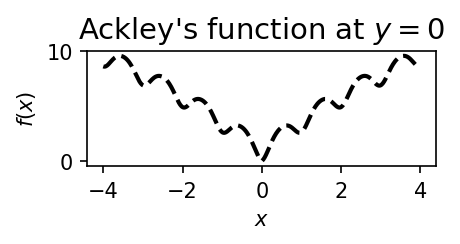

In [10]:
# let us view the function
plt.figure(figsize=[3,1], dpi=150)

# data
X = np.linspace(-4, 4, 500)
Y = ackley_1d(X)

# plotting
plt.plot(X, Y, 'k--',linewidth=2); 
plt.title("""Ackley's function at $y=0$""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.show();

In [11]:
# let us draw 20 random samples of the Ackley's function
x_observed = np.random.uniform(-4, 4, 20)
y_observed = ackley_1d(x_observed)

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_predict
from sklearn import datasets
from sklearn.metrics import r2_score

# let us use the Matern kernel
K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

# instance of GP
gp = GaussianProcessRegressor(kernel=K)

# fitting the GP
gp.fit(x_observed.reshape(-1,1), y_observed)

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5))

In [13]:
# let us check the learned model over all of the input space
X_ = np.linspace(-4, 4, 500)
y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)

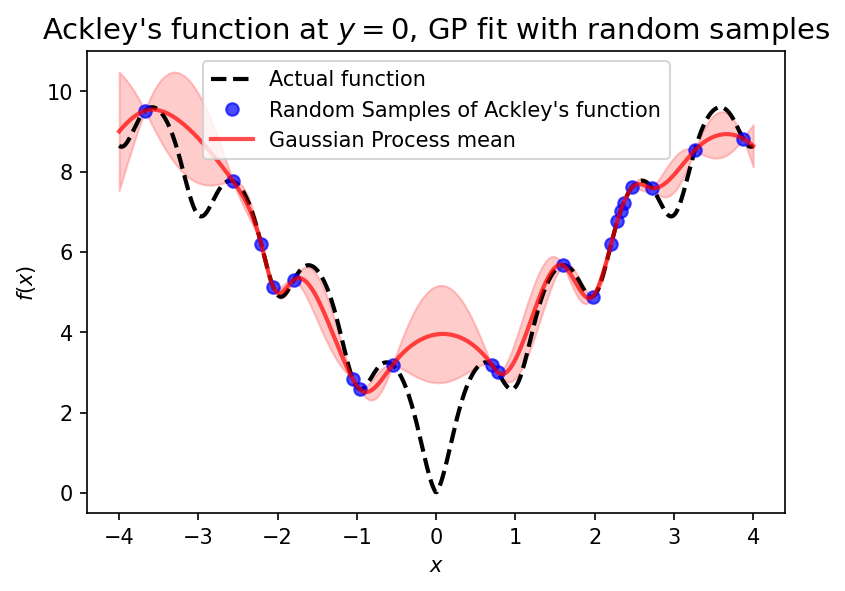

In [20]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[6,4], dpi=150)

# data
Y = ackley_1d(X_)

# plotting
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');
plt.plot(x_observed, y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=0.7)
plt.plot(X_, y_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='r')
plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

In [21]:
# function samples
y_samples = gp.sample_y(X_.reshape(-1,1), 10)

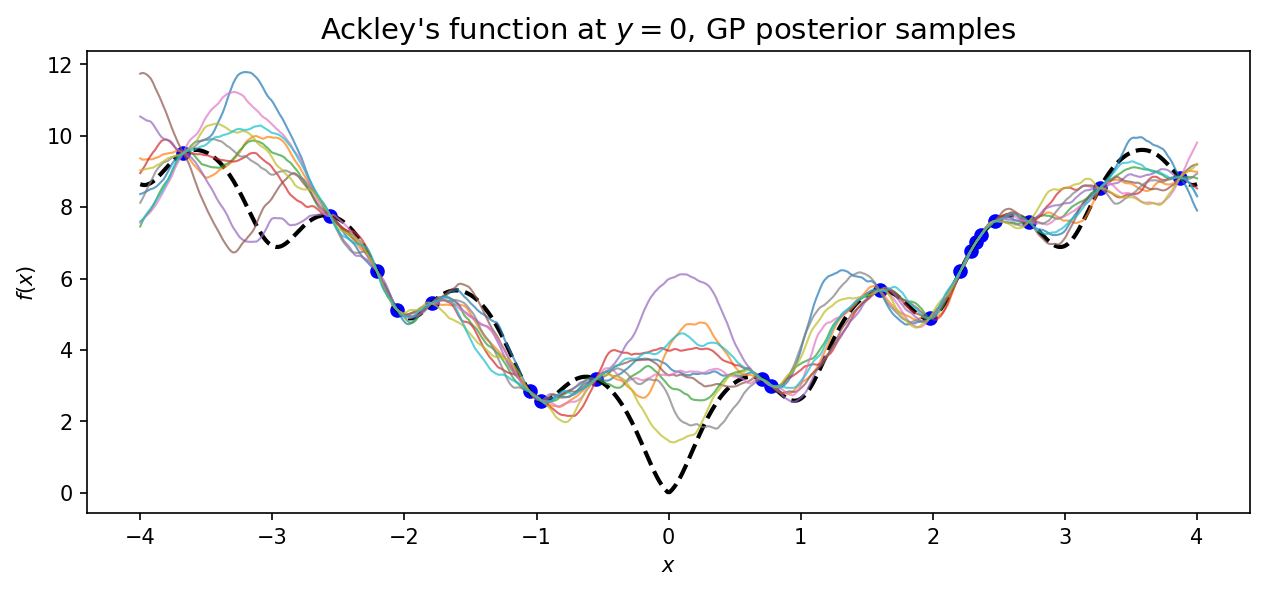

In [22]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[10,4], dpi=150)

# plotting random observations of function
plt.plot(x_observed, y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=1.0)
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');


# plotting all the posteriors
for posterior_sample in y_samples.T:
    plt.plot(X_, posterior_sample, label="""Random Samples of Ackley's function""", alpha=0.7, linewidth=1)

# title and labels    
plt.title("""Ackley's function at $y=0$, GP posterior samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.show();

In [1]:
# our TS-GP optimizer
class ThompsonSamplingGP:
    
    # initialization
    def __init__(self, n_random_draws, objective, x_bounds, interval_resolution=1000):
                
        # number of random samples before starting the optimization
        self.n_random_draws = n_random_draws
        
        # the objective is the function we're trying to optimize
        self.objective = objective
        
        # the bounds tell us the interval of x we can work
        self.bounds = x_bounds
        
        # interval resolution is defined as how many points we will use to 
        # represent the posterior sample
        # we also define the x grid
        self.interval_resolution = interval_resolution
        self.X_grid = np.linspace(self.bounds[0], self.bounds[1], self.interval_resolution)
        
        # also initializing our design matrix and target variable
        self.X = np.array([]); self.y = np.array([])
        
    # fitting process
    def fit(self, X, y):
        
        # let us use the Matern kernel
        K = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)

        # instance of GP
        gp = GaussianProcessRegressor(kernel=K)

        # fitting the GP
        gp.fit(X, y)
        
        # return the fitted model
        return gp
    
    # process of choosing next point
    def choose_next_sample(self):
        
        # if we do not have enough samples, sample randomly from bounds
        if self.X.shape[0] < self.n_random_draws:
            next_sample = np.random.uniform(self.bounds[0], self.bounds[1],1)[0]
        
        # if we do, we fit the GP and choose the next point based on the posterior draw minimum
        else:
            # 1. Fit the GP to the observations we have
            self.gp = self.fit(self.X.reshape(-1,1), self.y)
            
            # 2. Draw one sample (a function) from the posterior
            posterior_sample = self.gp.sample_y(self.X_grid.reshape(-1,1), 1).T[0]
            
            # 3. Choose next point as the optimum of the sample
            which_min = np.argmin(posterior_sample)
            next_sample = self.X_grid[which_min]
        
            # let us also get the std from the posterior, for visualization purposes
            posterior_mean, posterior_std = self.gp.predict(self.X_grid.reshape(-1,1), return_std=True)
        
        # let us observe the objective and append this new data to our X and y
        next_observation = self.objective(next_sample)
        self.X = np.append(self.X, next_sample)
        self.y = np.append(self.y, next_observation)
        
        # return everything if possible
        try:
            # returning values of interest
            return self.X, self.y, self.X_grid, posterior_sample, posterior_mean, posterior_std
        
        # if not, return whats possible to return
        except:
            return (self.X, self.y, self.X_grid, np.array([np.mean(self.y)]*self.interval_resolution), 
                    np.array([np.mean(self.y)]*self.interval_resolution), np.array([0]*self.interval_resolution))

c:\DATA\PythonEnv\large_scale\emuenv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\DATA\PythonEnv\large_scale\emuenv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# let us check the learned model over all of the input space
X_ = np.linspace(-4, 4, 500)
y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)

In [ ]:
# clearing past figures
plt.close('all')

# plotting!
plt.figure(figsize=[6,4], dpi=150)

# data
Y = ackley_1d(X_)

# plotting
plt.plot(X_, Y, 'k--', linewidth=2, label='Actual function');
plt.plot(x_observed, y_observed, 'bo', label="""Random Samples of Ackley's function""", alpha=0.7)
plt.plot(X_, y_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='r')
plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show()